
# The Distribution of Assets By Age

National registry data on income and wealth from Scandinavian countries has recently become available (with a lot of security) to some (lucky!) researchers.   These data offer a uniquely powerful tool for testing (and improving) our models of consumption and saving behavior over the life cycle.


But as of this writing (in March of 2019), the data are so new that there do not seem to be any published attempts to compare the data to the implications a standard life cycle model with income uncertainty, constraints, and other modern features.

This notebook is an example of how one could counstruct a life cycle model with the HARK toolkit that would make predictions about the model analogues of the raw data statistics that are available.  

For example, the papers have shown information about the growth rate of assets at different ages over the life cycle.  Here, we show how (under a given parameterization) we could produce the life cycle model's prediction about the distribution of assets at age 65 and age 66, and the growth rate between 65 and 66. 

The parameters of the model have not been optmized to match features of the Norwegian data; a first step in "structural" estimation would be to calibrate the inputs to the model (like the profile of income over the life cycle, and the magnitude of income shocks), and then to find the values of parameters like the time preference rate that allow the model to fit the data best.

An interesting question is whether this exercise will suggest that it is necessary to allow for _ex ante_ heterogeneity in such preference parameters.

This seems likely; a paper by [<cite data-cite="6202365/7MR8GUVS"></cite>](https://www.econ2.jhu.edu/people/ccarroll/papers/cstwMPC) (all of whose results were constructed using the HARK toolkit) finds that, if all other parameters (e.g., rates of return on savings) are the same, models of this kind require substantial heterogeneity in preferences to generate the degree of inequality in U.S. data.

But in one of the many new and interesting findings from the Norwegian data, <cite data-cite="6202365/B9BGV9W3"></cite> have shown that there is substantial heterogeneity in rates of return, even on wealth held in public markets.  

[Derin Aksit](https://github.com/econ-ark/REMARK) has shown that the degree of time preference heterogeneity needed to match observed inequality is considerably less when rate-of-return heterogeneity is calibrated to match these data.

In [1]:
# Initial imports and notebook setup, click arrow to show

import HARK.ConsumptionSaving.ConsIndShockModel as Model        # The consumption-saving micro model
import EstimationParameters as Params    # Parameters for the consumer type and the estimation
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools

import numpy as np

In [2]:
# Set up default values for CRRA, DiscFac, and simulation variables in the dictionary 
Params.init_consumer_objects["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_consumer_objects["DiscFac"]= 0.97         # Default intertemporal discount factor (beta)
Params.init_consumer_objects["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_consumer_objects["aNrmInitMean"]= -10.0   # Mean of log initial assets 
Params.init_consumer_objects["aNrmInitStd"]= 1.0      # Standard deviation of log initial assets
Params.init_consumer_objects["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_consumer_objects["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

In [3]:
# Make a lifecycle consumer to be used for estimation
LifeCyclePop = Model.IndShockConsumerType(**Params.init_consumer_objects)

In [4]:
# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpack('cFunc')                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrmNow','pLvl','mNrm','cNrm','TranShkNow']

LifeCyclePop.T_sim = 120                        # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop.initializeSim()                    # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()                         # Simulate a population behaving according to this model

/Users/ms/dev/HARK/HARK/interpolation.py:1710: RuntimeWarning: All-NaN slice encountered
  y = np.nanmin(fx,axis=1)


Consumption as a function of market resources while working:


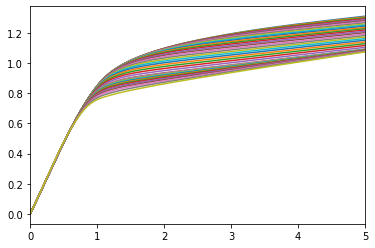

In [5]:
# Plot the consumption functions during working life

print('Consumption as a function of market resources while working:')
mMin = min([LifeCyclePop.solution[t].mNrmMin for t in range(LifeCyclePop.T_cycle)])
plotFuncs(LifeCyclePop.cFunc[:LifeCyclePop.T_retire],mMin,5)

In [6]:
# Define the saving rate function
def savingRateFunc(SomeType, m):
    """
    Parameters:
    ----------
        SomeType: 
             Agent type that has been solved and simulated.
        
        
    Returns:
    --------
        SavingRate: float
    
    """
    inc = (SomeType.Rfree -1.)*(m-1.)+1.
    cons = SomeType.solution[0].cFunc(m)
    Saving = inc - cons
    SavingRate = Saving / inc
    return SavingRate  

In [7]:
# Create a Giant matrix gathering useful data:
# 't_now', 'aNrmNow_hist', 'cNrmNow_hist', employment-status in date t, in date t-1, aLvlGro_hist, Saving rate

w, h = 1, LifeCyclePop.T_cycle
giant_list = [[0 for x in range(w)] for y in range(h)]
SavingRate_list = []

import warnings
warnings.filterwarnings("ignore") # Suppress some disturbing but harmless warnings

for t in range(1,LifeCyclePop.T_cycle+1):
    #aLvlGro_hist[0] = 0 # set the first growth rate to 0, since there is no data for period 0
    aLvlGroNow = np.log(LifeCyclePop.history['aNrmNow'][t]/LifeCyclePop.history['aNrmNow'][t-1]) # (10000,)

    # Call the saving rate function with test value for 
    SavingRate = savingRateFunc(LifeCyclePop, LifeCyclePop.history['mNrm'][t] )
      
    SavingRate_list.append(SavingRate)

    # Create elements of matrix list
    matrix_list = [0 for number in range(7)]
    matrix_list[0] = t
    matrix_list[1] = LifeCyclePop.history['aNrmNow'][t]
    matrix_list[2] = LifeCyclePop.history['cNrm'][t]
    matrix_list[3] = LifeCyclePop.history['TranShkNow'][t]
    matrix_list[4] = LifeCyclePop.history['TranShkNow'][t-1]
    matrix_list[5] = aLvlGroNow
    matrix_list[6] = SavingRate
    
    giant_list[t-1] = matrix_list
    
# Print command disabled to prevent giant print!
#print giant_list

In [8]:
# Construct the level of assets A from a*p where a is the ratio to permanent income p
LifeCyclePop.history['aLvlNow'] = LifeCyclePop.history['aNrmNow']*LifeCyclePop.history['pLvl']
aGro41=LifeCyclePop.history['aLvlNow'][41]/LifeCyclePop.history['aLvlNow'][40]
aGro41NoU=aGro41[aGro41[:]>0.2] # Throw out extreme outliers

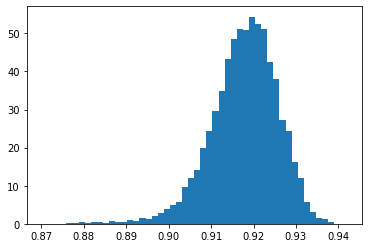

In [9]:
# Plot the distribution of growth rates of wealth between age 65 and 66 (=25 + 41)
from matplotlib import pyplot as plt
n, bins, patches = plt.hist(aGro41NoU,50,density=True)